# 📌 Problem Statement
### The objective of this assignment is to build a regression model that accurately predicts the airline ticket prices based on various features such as the airline name, source and destination cities, departure and arrival times, stops, travel class, duration, and number of days left for departure.

### Importing different libraries used for data processing 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #plotting
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


#### Reading train.csv and test.csv

In [2]:
train=pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv")
test=pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv")

# Identifying Data Types

In [3]:
dtypes=pd.DataFrame({
    'Column Name': train.columns,
    'Data types': train.dtypes.values
})
dtypes

#other methods
#train.dtypes <--- not a method but a property
#train.info()  <--- method/function

,Column Name,Data types
0,id,int64
1,airline,object
2,flight,object
3,source,object
4,departure,object
5,stops,object
6,arrival,object
7,destination,object
8,class,object
9,duration,float64


# Descriptive Statistics of Data

In [4]:
train.describe()

,id,duration,days_left,price
count,40000.00000,36987.000000,35562.000000,40000.00000
mean,19999.50000,12.004088,26.197936,20801.49025
std,11547.14972,7.108063,13.469232,22729.14842
min,0.00000,0.830000,1.000000,1105.00000
25%,9999.75000,6.670000,15.000000,4687.00000
50%,19999.50000,11.080000,26.000000,7353.00000
75%,29999.25000,15.920000,38.000000,42521.00000
max,39999.00000,47.080000,49.000000,114704.00000


# Handling Missing values

### Identifying Missing values

In [5]:
missing=train.isnull().sum() #missing is pandas Series (1D labelled array)
#print(missing)
missing=missing[missing>0] #filter outs columns which do not have missing values
missing_df=pd.DataFrame({
    "Column_Name" : missing.index,
    "Number of missing values" : missing.values
})
#print(missing)
missing_df

,Column_Name,Number of missing values
0,airline,4613
1,departure,4792
2,stops,2319
3,duration,3013
4,days_left,4438


### Handling these values

* For **CATEGORICAL** data: Use **MODE** imputation
* For NUMERICAL data: Use **MEAN** or **MEDIAN** imputation

#### Categorical Columns (airplane,departure,stops)

In [6]:
categorical=["airline","departure","stops"]

In [7]:
train_clean=train.copy()
for col in categorical:
    mode_value = train[col].mode()[0]
    train_clean[col] = train[col].fillna(mode_value)


#### Numerical Columns (duration, days_left)


These are used to check the skewness of the graph and how the data is distributed.
If the Graph is skewed,it is better to use MEDIAN imputation(or using median values to fill missing values)
If the Graph is evenly distributed , it is better to use MEAN imputation

In [8]:
#sns.histplot(train['duration'].dropna(), kde=True)
#sns.histplot(train['days_left'].dropna(), kde=True)
print(train['days_left'].skew())
print(train['duration'].skew())

-0.05105719418483811
0.6083600497613025



**> So it is better to use MEAN imputation for "days_left" And MEDIAN imputation for "duration"**


In [9]:
numerical=["duration","days_left"]

for col in numerical:
    if abs(train[col].skew())>0.5:
        train_clean[col] = train[col].fillna(train[col].median()) #more robust for skewed data
    else:
        train_clean[col] = train[col].fillna(train[col].mean()) #better for symmeteric distribution

In [10]:
train_clean.isnull().sum() #to show that now no missing values are there

id             0
airline        0
flight         0
source         0
departure      0
stops          0
arrival        0
destination    0
class          0
duration       0
days_left      0
price          0
dtype: int64

# Handling Duplicate values

### Identifying Duplicates

In [11]:
duplicates=train_clean[train_clean.duplicated()]
num_of_duplicates=duplicates.shape[0]

print(f"The number of duplicate rows: {num_of_duplicates}" )

The number of duplicate rows: 0


### Handling these duplicates

In [12]:
train_clean=train_clean.drop_duplicates()
print(f"The number iof duplicates after removal: {train_clean.duplicated().sum()}")

The number iof duplicates after removal: 0


# Handling Outliers

In [13]:
print(f"Shape of the cleaned dataset: {train_clean.shape}")

Shape of the cleaned dataset: (40000, 12)


<Axes: xlabel='price'>

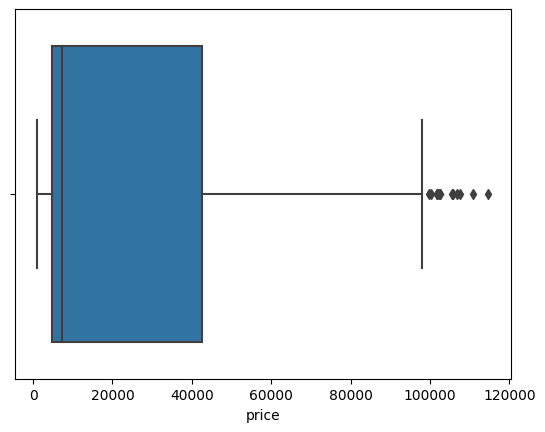

In [14]:
sns.boxplot(x=train_clean['price'])

In [15]:
#sns.boxplot(x=train_clean['column_name'])--> for visualizing
numeric_cols = train_clean.select_dtypes(include=['int64', 'float64']).columns
outlier_counts={}
def outliers(train_clean,cols):
    for col in cols:
        Q1 = train_clean[col].quantile(0.25)
        Q3 = train_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = train_clean[(train_clean[col] < lower) | (train_clean[col] > upper)]
        outlier_counts[col] = outliers.shape[0]
    return outlier_counts
result=outliers(train_clean,numeric_cols)
print(f"The total number of outliers in columns:{result}")

The total number of outliers in columns:{'id': 0, 'duration': 470, 'days_left': 0, 'price': 14}


In [16]:
print(f"Original shape: {train_clean.shape}")

numerical_cols = train_clean.select_dtypes(include=["int64", "float64"]).columns

def remove_outliers(train_clean, cols):
    for col in cols:
        Q1 = train_clean[col].quantile(0.25)
        Q3 = train_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train_clean = train_clean[(train_clean[col] >= lower_bound) & (train_clean[col] <= upper_bound)]
    return train_clean

train_clean = remove_outliers(train_clean, numerical_cols)

print(f"Shape after outlier removed: {train_clean.shape}")

Original shape: (40000, 12)
Shape after outlier removed: (39517, 12)


# Data Visualization & Key Insights

## 1. Average Price by Airline

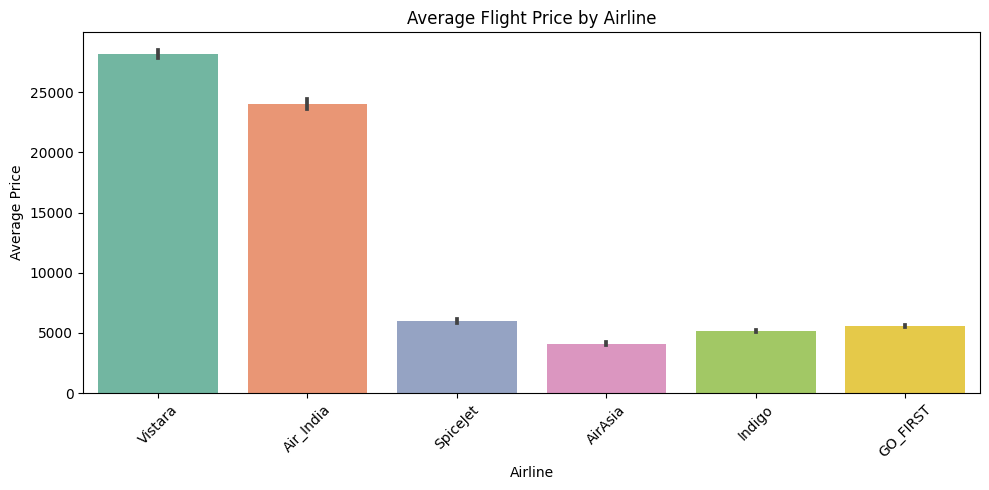

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(data=train_clean, x='airline', y='price', estimator='mean', palette='Set2')
plt.title('Average Flight Price by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




This bar plot shows the average ticket price for each airline.

**Insight:**  
Different airlines have varied pricing. Premium airlines like **Vistara or Air India charge more**, while budget airlines like **IndiGo or SpiceJet typically offer lower fares**.


## 2. Duration vs Price

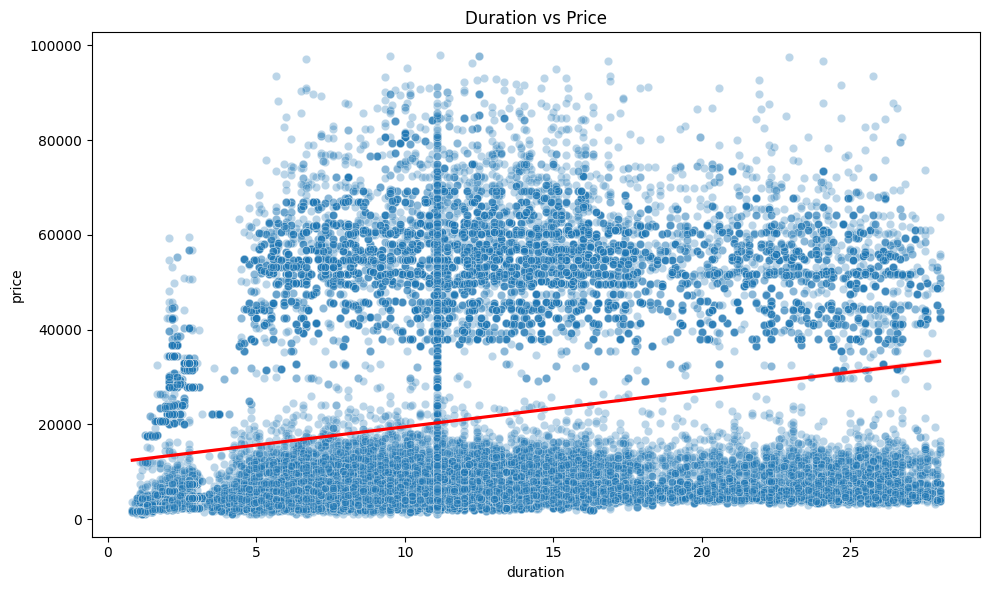

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_clean, x='duration', y='price', alpha=0.3)
sns.regplot(data=train_clean, x='duration', y='price', scatter=False, color='red')
plt.title('Duration vs Price')
plt.tight_layout()
plt.show()



Scatter plot showing the relationship between flight duration and price. A regression line indicates the trend.

**Insight:**  
There’s a weak positive correlation — longer flights can cost more. However, pricing also depends on other factors like class, route, and stops.


## 3. Price Distribution by Class

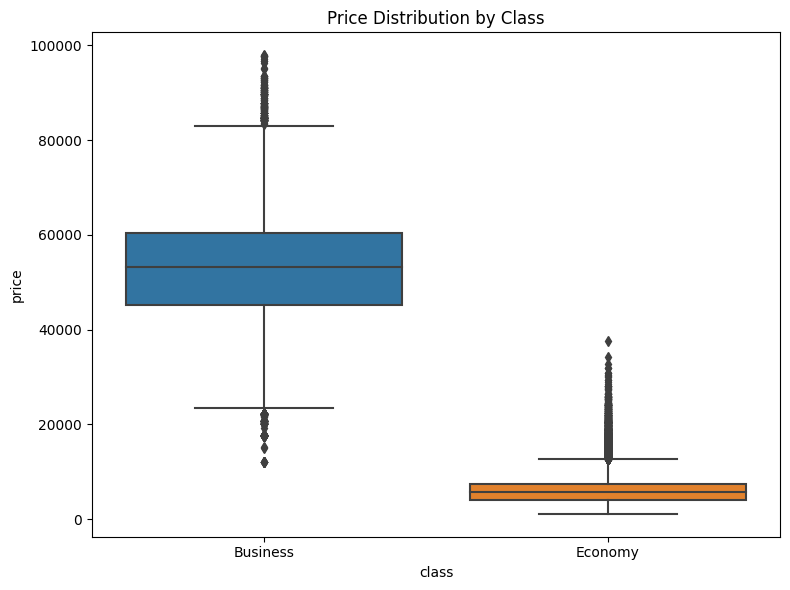

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_clean, x='class', y='price')
plt.title('Price Distribution by Class')
plt.tight_layout()
plt.show()




A box plot comparing the distribution of ticket prices between Economy and Business class.

**Insight:**  
Business class tickets are significantly more expensive, with a wider price range. This plot also reveals outliers and median prices for both classes.


## 4. Average Price by Number of Stops

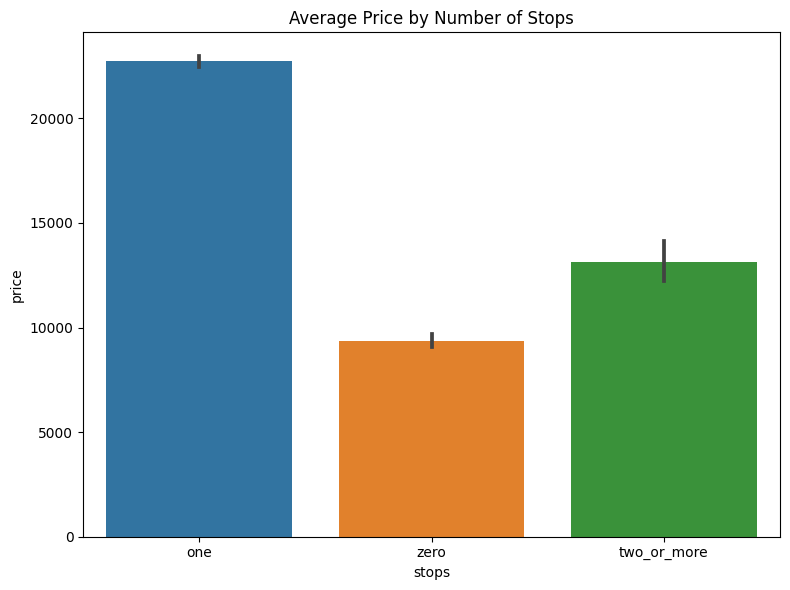

In [20]:
plt.figure(figsize=(8, 6))
sns.barplot(data=train_clean, x='stops', y='price', estimator=np.mean)
plt.title('Average Price by Number of Stops')
plt.tight_layout()
plt.show()




Bar plot displaying how ticket prices vary with the number of stops (zero, one, etc.).

**Insight:**  
Flights with no stops (direct) are usually more expensive. Adding stops tends to reduce prices due to less convenience.


# Scaling Numerical & Encoding Categorical features

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [22]:
# Step 1: Input and target
X = train_clean.drop(columns=['price'])
y = train_clean['price']

In [23]:
# Step 2: Custom encode 'stops' and 'class'
stops_map = {'zero': 0, 'one': 1, 'two_or_more': 2}
class_map = {'Economy': 0, 'Business': 1}

X['stops_encoded'] = X['stops'].map(stops_map)
X['class_encoded'] = X['class'].map(class_map)
# Drop original columns
X.drop(columns=['stops', 'class'], inplace=True)

In [24]:
# Step 3: Define feature types
numerical_cols = ['duration', 'days_left']
categorical_cols = ['airline', 'source', 'destination', 'departure', 'arrival']

In [25]:
# Step 4: Transform features
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
# Scale numerical columns
X_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_cols]),
                        columns=[col + '_scaled' for col in numerical_cols],
                        index=X.index)

# One-hot encode categorical columns
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_cols]),
                     columns=ohe.get_feature_names_out(categorical_cols),
                     index=X.index)

# Keep encoded 'stops' and 'class'
X_others = X.drop(columns=numerical_cols + categorical_cols)  # Contains stops_encoded, class_encoded


In [26]:
# Step 5: Combine all features
X_final = pd.concat([X_scaled, X_ohe, X_others], axis=1)

In [27]:
X_final.dtypes[X_final.dtypes == 'object']

flight    object
dtype: object

In [28]:
X_final.drop(columns=['flight'], inplace=True)

In [29]:
X_final = X_final.drop(columns=['id'], errors='ignore')

In [30]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


# Model Building

## 1. Linear Regression

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [32]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train,y_train)
prediction = lr.predict(X_test)
lasso_r2 = r2_score(y_test, prediction)
lasso_mae = mean_absolute_error(y_test, prediction)
lasso_rmse = np.sqrt(mean_squared_error(y_test, prediction))

print(f'R2 Score: {lasso_r2}')
print(f'MAE: {lasso_mae}')
print(f'RMSE: {lasso_rmse}')

R2 Score: 0.9121423207145324
MAE: 4478.240146466331
RMSE: 6726.321874377597


## 2. Ridge Regression

In [33]:
from sklearn.linear_model import Ridge
rid_model=Ridge()
rid_model.fit(X_train,y_train)
prediction=rid_model.predict(X_test)
print(f'R2 Score: {r2_score(y_test, prediction)}')
print(f'MAE:{mean_absolute_error(y_test, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}')

R2 Score: 0.9121426822141394
MAE:4478.17185645566
RMSE: 6726.308036286065


## 3. Lasso Regression

In [34]:
from sklearn.linear_model import Lasso
las_model=Lasso()
las_model.fit(X_train,y_train)
prediction=las_model.predict(X_test)
print(f'R2 Score:{r2_score(y_test, prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}')

R2 Score:0.91214650126693
MAE: 4476.456227523162
RMSE: 6726.161842404395


## 4. Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
prediction=rf.predict(X_test)
print(f'R2 Score:{r2_score(y_test,prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}')

R2 Score:0.9702186517196661
MAE: 2099.26137254394
RMSE: 3916.155785498313


## 5. Gradient Boosting Regressor

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gb=GradientBoostingRegressor()
gb.fit(X_train,y_train)
prediction=gb.predict(X_test)
print(f'R2 Score:{r2_score(y_test,prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}')

R2 Score:0.9493716376250196
MAE: 3070.8275165156583
RMSE: 5106.045988114411


## 6. XG Boost Regressor

In [37]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [38]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print(f'R2 Score:{r2_score(y_test,prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}')

R2 Score:0.9652334110729845
MAE: 2461.7945696101015
RMSE: 4231.251337825422


## 7. Extra Trees Regressor

In [39]:
from sklearn.ensemble import ExtraTreesRegressor
et=ExtraTreesRegressor()
et.fit(X_train,y_train)
prediction=et.predict(X_test)
print(f'R2 Score:{r2_score(y_test,prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}')

R2 Score:0.9658517175818762
MAE: 2101.118174552969
RMSE: 4193.457195191317


## Other Models checked -->LightBGM, CatBoost, AdaBoost and KNeighbours

### LightBGM and CatBoost

In [40]:
# pip install lightgbm catboost
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# # Initialize models
# lgb_model = LGBMRegressor(random_state=42)
# cat_model = CatBoostRegressor(verbose=0, random_state=42)  # Set verbose=0 to reduce logs
# lgb_model.fit(X_train, y_train)
# cat_model.fit(X_train, y_train)
# from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# # Predict
# lgb_pred = lgb_model.predict(X_test)
# cat_pred = cat_model.predict(X_test)

# # Evaluate
# print("LightGBM R²:", r2_score(y_test, lgb_pred))
# print("CatBoost R²:", r2_score(y_test, cat_pred))
# print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test, lgb_pred)))
# print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, cat_pred)))


### AdaBoostRegressor

In [41]:
# from sklearn.ensemble import AdaBoostRegressor
# ab=AdaBoostRegressor()
# ab.fit(X_train,y_train)
# prediction=ab.predict(X_test)
# print(r2_score(y_test,prediction))
# print(mean_absolute_error(y_test, prediction))
# print(np.sqrt(mean_squared_error(y_test, prediction)))

### KNeighborsRegressor

In [42]:
# from sklearn.neighbors import KNeighborsRegressor
# vr=KNeighborsRegressor()
# vr.fit(X_train,y_train)
# prediction=vr.predict(X_test)
# print(r2_score(y_test,prediction))
# print(mean_absolute_error(y_test, prediction))
# print(np.sqrt(mean_squared_error(y_test, prediction)))

**It is clear that the best result is obtained by RandomForest, XGBoost, ExtraTrees and CatBoost Regressors. So we are doing Hyperparameter Tuning of these models**

# Hyperparameter Tuning

## 1. Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10,20, None],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(rf, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

print("Best Params:", grid_rf.best_params_)
print("Best R² (CV):", grid_rf.best_score_)
print("Test R²:", grid_rf.best_estimator_.score(X_test, y_test))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best R² (CV): 0.9669004412000483
Test R²: 0.9711536208444668


## 2. Ridge Model

In [44]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

ridge_grid.fit(X_train, y_train)

print("🔧 Best alpha (Ridge):", ridge_grid.best_params_['alpha'])
print("📈 Best CV R² Score (Ridge):", ridge_grid.best_score_)
print("🧪 Test R² Score (Ridge):", ridge_grid.best_estimator_.score(X_test, y_test))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
🔧 Best alpha (Ridge): 1
📈 Best CV R² Score (Ridge): 0.9076259371201763
🧪 Test R² Score (Ridge): 0.9121426822141394


## 3. Extra Trees Regressor

In [45]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

et = ExtraTreesRegressor(random_state=42)

param_grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_et = GridSearchCV(
    estimator=et,
    param_grid=param_grid_et,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_et.fit(X_train, y_train)

print("✅ Best Params (ExtraTrees):", grid_et.best_params_)
print("📈 Best CV R² Score:", grid_et.best_score_)
print("🧪 Test R² Score:", grid_et.best_estimator_.score(X_test, y_test))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Params (ExtraTrees): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
📈 Best CV R² Score: 0.9631336292853127
🧪 Test R² Score: 0.9664448701984771


## 4. XG Boost Regressor

In [46]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV



param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb = XGBRegressor(random_state=42)
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)

print("✅ Best Params (XGBoost):", grid_xgb.best_params_)
print("📈 Best CV R² Score:", grid_xgb.best_score_)
print("🧪 Test R² Score:", grid_xgb.best_estimator_.score(X_test, y_test))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Params (XGBoost): {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
📈 Best CV R² Score: 0.9680961434304763
🧪 Test R² Score: 0.9713583711629197


# Comparison of model performances

In [47]:
models = {
    'Random Forest': grid_rf.best_estimator_,
    'Extra Trees': grid_et.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'Ridge': ridge_grid.best_estimator_,
    'Lasso': las_model,
    'Linear Regression': lr, 
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append((name, r2, mse, rmse))

# Create results DataFrame
import pandas as pd
results_df = pd.DataFrame(results, columns=['Model', 'R² Score', 'MSE', 'RMSE'])
results_df.sort_values(by='R² Score', ascending=False, inplace=True)

print(results_df)


               Model  R² Score           MSE         RMSE
2            XGBoost  0.971358  1.474936e+07  3840.489997
0      Random Forest  0.971154  1.485480e+07  3854.192800
1        Extra Trees  0.966445  1.727963e+07  4156.877665
4              Lasso  0.912147  4.524125e+07  6726.161842
3              Ridge  0.912143  4.524322e+07  6726.308036
5  Linear Regression  0.912142  4.524341e+07  6726.321874


## Cleaning of Test Data

In [48]:
print(test['days_left'].skew())
print(test['duration'].skew())

-0.037695018303712816
0.6076423127087754


In [49]:
print(test['stops'].unique())


['zero' 'one' nan 'two_or_more']


In [50]:
test.isnull().sum()

id               0
airline        548
flight           0
source           0
departure      920
stops          651
arrival          0
destination      0
class            0
duration       582
days_left      696
dtype: int64

In [51]:
# Make a copy
test_clean = test.copy()

# Drop irrelevant column
test_clean.drop(columns=['flight'], inplace=True)
test_clean['airline'] = test_clean['airline'].fillna(test_clean['airline'].mode()[0])
test_clean['departure'] = test_clean['departure'].fillna(test_clean['departure'].mode()[0])
test_clean['stops'] = test_clean['stops'].fillna(test_clean['stops'].mode()[0])
# Fill missing numerical values
test_clean['duration'] = test_clean['duration'].fillna(train_clean['duration'].median())
test_clean['days_left'] = test_clean['days_left'].fillna(train_clean['days_left'].mean())

# Map categorical values (same as training)
stops_map = {'zero': 0, 'one': 1, 'two_or_more': 2}
class_map = {'Economy': 0, 'Business': 1}

test_clean['stops_encoded'] = test_clean['stops'].map(stops_map)
test_clean['class_encoded'] = test_clean['class'].map(class_map)

# Drop original stops/class
test_clean.drop(columns=['stops', 'class'], inplace=True)


In [52]:
print(test_clean.columns)
print(test_clean[['duration', 'days_left']].head())


Index(['id', 'airline', 'source', 'departure', 'arrival', 'destination',
       'duration', 'days_left', 'stops_encoded', 'class_encoded'],
      dtype='object')
   duration  days_left
0      2.67       18.0
1     11.08        5.0
2     11.08       44.0
3     21.00       26.0
4      7.25       22.0


In [53]:
# Convert columns to float
test_clean['duration'] = test_clean['duration'].astype(float)
test_clean['days_left'] = test_clean['days_left'].astype(float)
test_clean.columns

Index(['id', 'airline', 'source', 'departure', 'arrival', 'destination',
       'duration', 'days_left', 'stops_encoded', 'class_encoded'],
      dtype='object')

In [54]:
# Step 1: Clean raw values (handle bad strings or missing entries)
test_clean['duration'] = pd.to_numeric(test_clean['duration'], errors='coerce')
test_clean['days_left'] = pd.to_numeric(test_clean['days_left'], errors='coerce')

# Step 2: Fill missing values using training stats
test_clean['duration']=test_clean['duration'].fillna(train_clean['duration'].median())
test_clean['days_left']=test_clean['days_left'].fillna(train_clean['days_left'].mean())

# Step 3: Verify they are now float
print(test_clean.dtypes[['duration', 'days_left']])

# Step 4: Print a few values to confirm it's good
print(test_clean[['duration', 'days_left']].head())

duration     float64
days_left    float64
dtype: object
   duration  days_left
0      2.67       18.0
1     11.08        5.0
2     11.08       44.0
3     21.00       26.0
4      7.25       22.0


In [55]:
X_train.columns

Index(['duration_scaled', 'days_left_scaled', 'airline_Air_India',
       'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet',
       'airline_Vistara', 'source_Chennai', 'source_Delhi', 'source_Hyderabad',
       'source_Kolkata', 'source_Mumbai', 'destination_Chennai',
       'destination_Delhi', 'destination_Hyderabad', 'destination_Kolkata',
       'destination_Mumbai', 'departure_Early_Morning', 'departure_Evening',
       'departure_Late_Night', 'departure_Morning', 'departure_Night',
       'arrival_Early_Morning', 'arrival_Evening', 'arrival_Late_Night',
       'arrival_Morning', 'arrival_Night', 'stops_encoded', 'class_encoded'],
      dtype='object')

## Scaling of Test Dataset

In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Step 3: Transform test numerical data
X_scaled_test = pd.DataFrame(
    scaler.transform(test_clean[numerical_cols]),
    columns=[col + '_scaled' for col in numerical_cols],
    index=test_clean.index
)

# Step 4: Transform test categorical data
X_ohe_test = pd.DataFrame(
    ohe.transform(test_clean[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=test_clean.index
)

# Step 5: Keep manually encoded columns
X_other_test = test_clean[['stops_encoded', 'class_encoded']]

# Step 6: Combine all into final test feature set
X_final_test = pd.concat([X_scaled_test, X_ohe_test, X_other_test], axis=1)

# Optional: check shape
print("Test set ready:", X_final_test.shape)


Test set ready: (10000, 29)


In [57]:
X_final_test.columns

Index(['duration_scaled', 'days_left_scaled', 'airline_Air_India',
       'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet',
       'airline_Vistara', 'source_Chennai', 'source_Delhi', 'source_Hyderabad',
       'source_Kolkata', 'source_Mumbai', 'destination_Chennai',
       'destination_Delhi', 'destination_Hyderabad', 'destination_Kolkata',
       'destination_Mumbai', 'departure_Early_Morning', 'departure_Evening',
       'departure_Late_Night', 'departure_Morning', 'departure_Night',
       'arrival_Early_Morning', 'arrival_Evening', 'arrival_Late_Night',
       'arrival_Morning', 'arrival_Night', 'stops_encoded', 'class_encoded'],
      dtype='object')

In [58]:
X_final_test.isnull().sum()


duration_scaled            0
days_left_scaled           0
airline_Air_India          0
airline_GO_FIRST           0
airline_Indigo             0
airline_SpiceJet           0
airline_Vistara            0
source_Chennai             0
source_Delhi               0
source_Hyderabad           0
source_Kolkata             0
source_Mumbai              0
destination_Chennai        0
destination_Delhi          0
destination_Hyderabad      0
destination_Kolkata        0
destination_Mumbai         0
departure_Early_Morning    0
departure_Evening          0
departure_Late_Night       0
departure_Morning          0
departure_Night            0
arrival_Early_Morning      0
arrival_Evening            0
arrival_Late_Night         0
arrival_Morning            0
arrival_Night              0
stops_encoded              0
class_encoded              0
dtype: int64

In [59]:
print(test.shape[0])           # Should be 10000
print(X_final_test.shape[0])   # Should also be 10000


10000
10000


# Final Submission

In [60]:
rf_pred = grid_rf.best_estimator_.predict(X_final_test)
xgb_pred = grid_xgb.best_estimator_.predict(X_final_test)
y_pred = 0.5 * rf_pred + 0.5 * xgb_pred

In [61]:
submission = pd.DataFrame({
    'id': test['id'],
    'price': y_pred.round(2)  # Optional rounding
})

submission.to_csv('submission.csv', index=False)

In [62]:
# import os

# # Replace with the exact filename you want to delete
# file_to_delete = 'submission.csv'

# # Delete if it exists
# if os.path.exists(file_to_delete):
#     os.remove(file_to_delete)
#     print(f"Deleted '{file_to_delete}'")
# else:
#     print(f"File '{file_to_delete}' not found")
